<a href="https://colab.research.google.com/github/cody628/git_test11/blob/main/AI_crime_prevention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
### kagle 사이트에서 dataset 받아오기
# install
!pip install kaggle --upgrade

In [2]:
# 저장된 kaggle.json 파일을 colb에 upload
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"seokjunhwang","key":"a007ef7fb89282433b2b741d89829e92"}'}

In [3]:
# kaggle.json 파일의 위치 변경
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
# 잘 저장되었는지 확인
!ls -1ha kaggle.json

kaggle.json


In [5]:
# 필요한 데이터셋 불러오기
!kaggle datasets download -d ankan1998/weapon-detection-dataset

 99% 480M/487M [00:06<00:00, 50.3MB/s]
100% 487M/487M [00:06<00:00, 73.2MB/s]


In [6]:
# 잘 저장되었는지 확인 후 unzip
!ls
!unzip weapon-detection-dataset.zip

kaggle.json  sample_data  weapon-detection-dataset.zip
Archive:  weapon-detection-dataset.zip
  inflating: Sohas_weapon-Detection/annotations/trainval.txt  
  inflating: Sohas_weapon-Detection/annotations/xmls/ABbframe00154.xml  
  inflating: Sohas_weapon-Detection/annotations/xmls/ABbframe00160.xml  
  inflating: Sohas_weapon-Detection/annotations/xmls/ABbframe00166.xml  
  inflating: Sohas_weapon-Detection/annotations/xmls/ABbframe00169.xml  
  inflating: Sohas_weapon-Detection/annotations/xmls/ABbframe00190.xml  
  inflating: Sohas_weapon-Detection/annotations/xmls/ABbframe00235.xml  
  inflating: Sohas_weapon-Detection/annotations/xmls/ABbframe00265.xml  
  inflating: Sohas_weapon-Detection/annotations/xmls/ABbframe00271.xml  
  inflating: Sohas_weapon-Detection/annotations/xmls/ABbframe00274.xml  
  inflating: Sohas_weapon-Detection/annotations/xmls/ABbframe00277.xml  
  inflating: Sohas_weapon-Detection/annotations/xmls/ABbframe00280.xml  
  inflating: Sohas_weapon-Detection/anno

In [7]:
### 주언진 이미지에 바운딩 박스를 시각화해 올바르게 레이블링된 데이터인지 확인
# 바운딩 박스 시각화 코드를 테스트하기 위해 필요한 패키지 불러옴
import os
import glob # 파일을 다루는 패키지
import matplotlib.pyplot as plt # 시각화 패키지
import matplotlib.image as mpimg
import matplotlib.patches as patches
from bs4 import BeautifulSoup # xml 문서 파일을 파싱하는 패키지

# glob 패키지를 이용해 dataset 불러오기
img_list = sorted(glob.glob('/content/Sohas_weapon-Detection/images/*'))
annot_list = sorted(glob.glob('/content/Sohas_weapon-Detection/annotations/xmls/*'))

# 각 폴더에 들어있는 파일 갯수 파악, 확인
print('img_list 갯수 : ', len(img_list))
print('annot_list 갯수 : ', len(annot_list))

# 각각의 폴더에 들어있는 파일이 제대로 있는지 확인 파일의 ID 순서가 동일한지 확인
print(img_list[:10])
print(annot_list[:10])

img_list 갯수 :  1000
annot_list 갯수 :  1000
['/content/Sohas_weapon-Detection/images/ABbframe00154.jpg', '/content/Sohas_weapon-Detection/images/ABbframe00160.jpg', '/content/Sohas_weapon-Detection/images/ABbframe00166.jpg', '/content/Sohas_weapon-Detection/images/ABbframe00169.jpg', '/content/Sohas_weapon-Detection/images/ABbframe00190.jpg', '/content/Sohas_weapon-Detection/images/ABbframe00235.jpg', '/content/Sohas_weapon-Detection/images/ABbframe00265.jpg', '/content/Sohas_weapon-Detection/images/ABbframe00271.jpg', '/content/Sohas_weapon-Detection/images/ABbframe00274.jpg', '/content/Sohas_weapon-Detection/images/ABbframe00277.jpg']
['/content/Sohas_weapon-Detection/annotations/xmls/ABbframe00154.xml', '/content/Sohas_weapon-Detection/annotations/xmls/ABbframe00160.xml', '/content/Sohas_weapon-Detection/annotations/xmls/ABbframe00166.xml', '/content/Sohas_weapon-Detection/annotations/xmls/ABbframe00169.xml', '/content/Sohas_weapon-Detection/annotations/xmls/ABbframe00190.xml', '/cont

In [8]:
### 바운딩 박스 시각화를 위한 함수 정의
# 바운딩 박스 좌표 값 반환
def generate_box(obj):
  xmin = float(obj.find('xmin').text)
  ymin = float(obj.find('ymin').text)
  xmax = float(obj.find('xmax').text)
  ymax = float(obj.find('ymax').text)

  return [xmin, ymin, xmax, ymax]

# 칼 바운딩 박스면 1로 칼이 아닌 바운딩 박스면 0으로 반환
def generate_label(obj):
  if obj.find('name').text == "knife":
    return 1
  return 0

# 'generate_box'와 'generate_label'를 각각 호출하여 반환된 값을 딕셔너리에 저장해 반환
def generate_target(file):
    with open(file) as f:
        data = f.read()
        soup = BeautifulSoup(data, "html.parser")
        objects = soup.find_all("object")

        num_objs = len(objects)

        boxes = []
        labels = []
        for i in objects:
            boxes.append(generate_box(i))
            labels.append(generate_label(i))

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels

        return target

# 이미지와 바운딩 박스를 함께 시각화 하는 함수(칼이면 초록색, 칼이 아니면 빨강색)
def plot_image(img_path, annotation):

    img = mpimg.imread(img_path)

    fig,ax = plt.subplots(1)
    ax.imshow(img)

    for idx in range(len(annotation["boxes"])):
        xmin, ymin, xmax, ymax = annotation["boxes"][idx]

        if annotation['labels'][idx] == 0 :
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='r',facecolor='none')

        else:
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='g',facecolor='none')

        ax.add_patch(rect)

    plt.show()

In [9]:
### 이미지 바운딩이 잘 되었는지 확인
# 아무 이미지를 골라 확인하기 위해 해당 이미지 인덱스 확인
img_list.index('/content/Sohas_weapon-Detection/images/DefenseKnifeAttack0173.jpg')

114

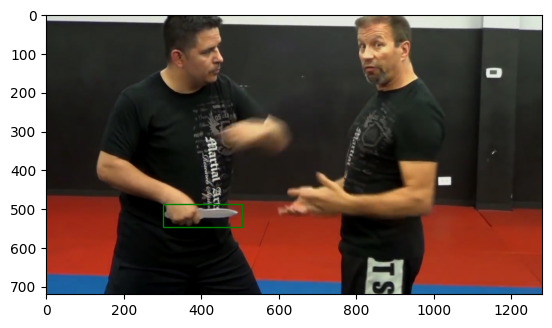

In [10]:
# bbox에 해당 이미지에서의 바운딩 박스 정보를 저장
bbox = generate_target(annot_list[114])

# 이미지 위치와 이미지에서의 바운딩 박스 정보를 주워 바운딩 박스 확인
plot_image(img_list[114], bbox)

In [11]:
### 이미지 Augmentation
# albumentations 모듈 업그레이드
!pip install --upgrade albumentations

In [12]:
### 바운딩 박스 시각화를 위한 함수 정의
# 바운딩 박스 시각화에 필요한 패키지
import os
import glob
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from bs4 import BeautifulSoup

# 바운딩 박스 좌표 값 반환
def generate_box(obj):
  xmin = float(obj.find('xmin').text)
  ymin = float(obj.find('ymin').text)
  xmax = float(obj.find('xmax').text)
  ymax = float(obj.find('ymax').text)

  return [xmin, ymin, xmax, ymax]

# 칼 바운딩 박스면 1로 칼이 아닌 바운딩 박스면 0으로 반환
def generate_label(obj):
  if obj.find('name').text == "knife":
    return 1
  return 0

# 'generate_box'와 'generate_label'를 각각 호출하여 반환된 값을 딕셔너리에 저장해 반환
def generate_target(file):
    with open(file) as f:
        data = f.read()
        soup = BeautifulSoup(data, "html.parser")
        objects = soup.find_all("object")

        num_objs = len(objects)

        boxes = []
        labels = []
        for i in objects:
            boxes.append(generate_box(i))
            labels.append(generate_label(i))

        # 추후 딥러닝 모델 학습을 위한 tenosr간의 연산을 준비
        boxes = torch.as_tensor(boxes, dtype = torch.float32)
        labels = torch.as_tensor(labels, dtype = torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels

        return target

# 이미지와 바운딩 박스를 함께 시각화 하는 함수(칼이면 초록색, 칼이 아니면 빨강색)
def plot_image_from_output(img_path, annotation):
    # pytorch에서는 이미지를 [채널, 세로, 가로]로 표현, matplotlib에서는 [가로, 세로, 채널]로 표현 따라서 채널순서 변경
    global img
    img = img.permute(1, 2, 0)

    fig,ax = plt.subplots(1)
    ax.imshow(img)

    for idx in range(len(annotation["boxes"])):
        xmin, ymin, xmax, ymax = annotation["boxes"][idx]

        if annotation['labels'][idx] == 0 :
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='r',facecolor='none')

        else:
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='g',facecolor='none')

        ax.add_patch(rect)

    plt.show()

In [13]:
### torchvision.transforms를 사용하기 위한 TorchvisionDataset 클래스 정의
from PIL import Image
import cv2
import numpy as np
import time
import torch
import torchvision
from torch.utils.data import Dataset
from torchvision import transforms
import albumentations
import albumentations.pytorch
from matplotlib import pyplot as plt
import os
import random

class TorchvisionKnifeDataset(Dataset):
  def __init__(self,path, transform = None):
    self.path = path
    self.imgs = list(sorted(os.listdir(self.path)))
    self.transform = transform

  def __len__(self):
    return len(self.imgs)

  # image를 불러온 다음 augmentation을 진행한다.
  def __getitem__(self, idx):
    file_image = self.imgs[idx]
    file_label = self.imgs[idx][:-3] + 'xml'
    img_path = os.path.join(self.path, file_image)

    if 'test' in self.path:
      label_path = os.path.join("/content/Sohas_weapon-Detection/anntations_test/xmls", file_label)
    else:
      label_path = os.path.join("/content/Sohas_weapon-Detection/annotations/xmls/", file_label)

    img = Image.open(img_path).convert("RGB")
    target = generate_target(label_path)

    # transform 파라미터에 저장돼 있는 qugmentation 규칙에 따라 augmentation이 이루워짐
    # 시간 측정을 위해 time 함수를 사용해 시간 측정한다.
    start_t = time.time()
    if self.transform:
      img = self.transform(img)

    total_time = (time.time() - start_t)

    return img, target, total_time

In [14]:
# torchvision에서 제공하는 함수를 활용해 이미지 augmentation을 진행
torchvision_transform = transforms.Compose([
    # 이미지를 (300, 300) 크기로 만듬
    transforms.Resize((300, 300)),

    # 224 크기로 자름
    transforms.RandomCrop(224),

    # 이미지의 밝기, 대비, 채도, 색조를 바꿔줌
    transforms.ColorJitter(brightness = 0.2, contrast = 0.2, saturation = 0.2, hue = 0.2),

    # 이미지 좌우 반전 적용
    transforms.RandomHorizontalFlip(p = 1),

    # tensor로 변환
    transforms.ToTensor()
])

torchvision_dataset = TorchvisionKnifeDataset(
    path = '/content/Sohas_weapon-Detection/images/',
    transform = torchvision_transform
)

transforms 적용 전


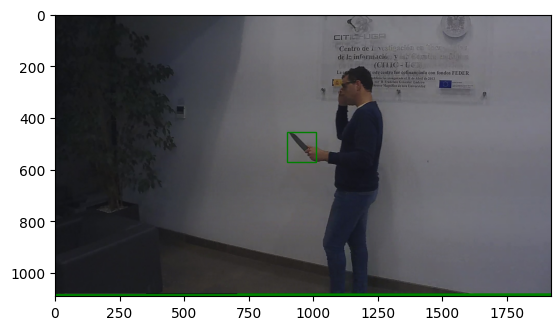

In [15]:
### 변경 전과 변경 후의 이미지를 비교
# 변경 전 이미지 확인
only_totensor = transforms.Compose([transforms.ToTensor()])

torchvision_dataset_no_transform = TorchvisionKnifeDataset(
    path = '/content/Sohas_weapon-Detection/images/',
    transform = only_totensor
)

img, annot, transform_time = torchvision_dataset_no_transform[0]
print('transforms 적용 전')
plot_image_from_output(img, annot)

transforms 적용 후


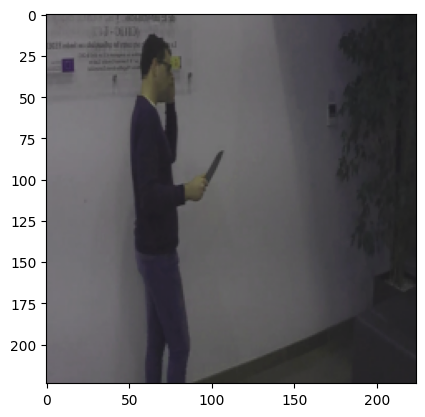

In [16]:
# 변경 후 이미지 확인
img, annot, transform_time = torchvision_dataset[0]

print('transforms 적용 후')
plot_image_from_output(img, annot)

In [17]:
### torchvision과 albumentation 모듈 비교를 위해 우선 torchvision 이미지 변환에 소요되는 시간 계산
total_time = 0

# 100장 변환을 하면서 처리 속도 계산
for i in range(100):
  smaple, _, transform_time = torchvision_dataset[0]
  total_time += transform_time

print("torchvision time: {}ms".format(total_time * 10))

torchvision time: 20.204827785491943ms


In [18]:
### albumentaion 모듈을 이용해서 데이터 전처리 하기
# albumentaion dataset 클래스를 정의
class AlbumentationsDataset(Dataset):
    def __init__(self, path, transform=None):
        self.path = path
        self.imgs = list(sorted(os.listdir(self.path)))
        self.transform = transform

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        file_image = self.imgs[idx]
        file_label = self.imgs[idx][:-3] + 'xml'
        img_path = os.path.join(self.path, file_image)

        if 'test' in self.path:
            label_path = os.path.join("/content/Sohas_weapon-Detection/anntations_test/xmls", file_label)
        else:
            label_path = os.path.join("/content/Sohas_weapon-Detection/annotations/xmls", file_label)

        # cv2 모듈을 이용하여 이미지를 읽고 RGB로 바꿔줌
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        target = generate_target(label_path)

        start_t = time.time()
        if self.transform:
            augmented = self.transform(image=image)
            total_time = (time.time() - start_t)
            image = augmented['image']


        return image, target, total_time

# albumentaions에서 제공하는 함수를 활용해 이미지 augmentation을 진행
albumentations_transform = albumentations.Compose([
    # 이미지를 (300, 300) 크기로 만듬
    albumentations.Resize(300, 300),

    # 224 크기로 자름
    albumentations.RandomCrop(224, 224),

    # 이미지의 밝기, 대비, 채도, 색조를 바꿔줌
    albumentations.ColorJitter(p=1),

    # 이미지 좌우 반전 적용
    albumentations.HorizontalFlip(p=1),

    # tensor로 전환
    albumentations.pytorch.ToTensorV2()
])

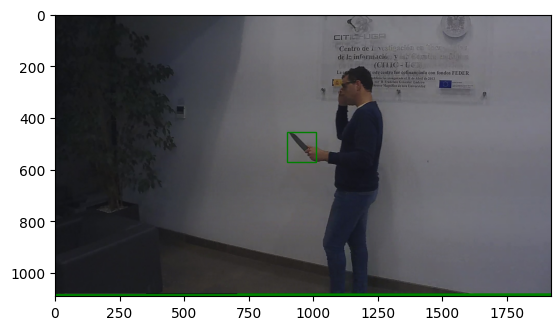

In [19]:
### 변경 전과 변경 후 이미지 비교
# 변경 전
img, annot, transform_time = torchvision_dataset_no_transform[0]
plot_image_from_output(img, annot)

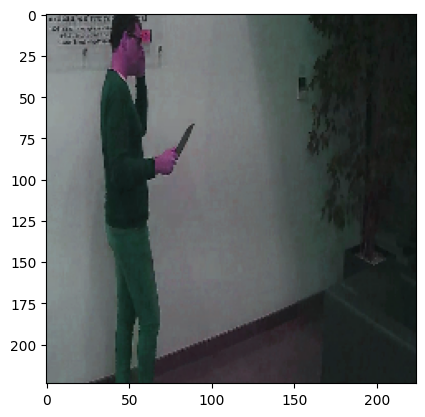

In [20]:
# 변경 후
albumentation_dataset = AlbumentationsDataset(
    path = '/content/Sohas_weapon-Detection/images/',
    transform = albumentations_transform
)

img, annot, transform_time = albumentation_dataset[0]
plot_image_from_output(img, annot)

In [21]:
### albumentation 모듈의 이미지 변환에 소요되는 시간 계산
total_time = 0

# 100장 변환을 하면서 처리 속도 계산
for i in range(100):
  sample, _, transform_time = albumentation_dataset[0]
  total_time += transform_time

  print("albumentations time/sample: {} ms".format(total_time*10))

albumentations time/sample: 0.03412008285522461 ms
albumentations time/sample: 0.0667428970336914 ms
albumentations time/sample: 0.09989261627197266 ms
albumentations time/sample: 0.13212203979492188 ms
albumentations time/sample: 0.16520023345947266 ms
albumentations time/sample: 0.19837141036987305 ms
albumentations time/sample: 0.23136138916015625 ms
albumentations time/sample: 0.2634596824645996 ms
albumentations time/sample: 0.29560089111328125 ms
albumentations time/sample: 0.3278493881225586 ms
albumentations time/sample: 0.35994529724121094 ms
albumentations time/sample: 0.39177894592285156 ms
albumentations time/sample: 0.42435407638549805 ms
albumentations time/sample: 0.4592275619506836 ms
albumentations time/sample: 0.49303293228149414 ms
albumentations time/sample: 0.525658130645752 ms
albumentations time/sample: 0.561976432800293 ms
albumentations time/sample: 0.5952095985412598 ms
albumentations time/sample: 0.6271982192993164 ms
albumentations time/sample: 0.66000461578

In [24]:
### 확률 기반 Augmentation 조합을 이용해서 데이터 전처리 하기
# albumentation은 oneof 함수를 제공해서 확률에 기반해서 전처리할 수 있음
albumentations_transform_oneof = albumentations.Compose([
    albumentations.Resize(300, 300),
    albumentations.RandomCrop(224, 224),

    # 좌우 반전, 90도 회번, 상하 반전을 1/3 확률 기반으로 처리
    albumentations.OneOf([
        albumentations.HorizontalFlip(p=1),
        albumentations.RandomRotate90(p=1),
        albumentations.VerticalFlip(p=1)
    ], p = 1),

    # 모션 블러, 왜곡, 가우스 노이즈를 1/3 확률 기반으로 처
    albumentations.OneOf([
        albumentations.MotionBlur(p=1),
        albumentations.OpticalDistortion(p=1),
        albumentations.GaussNoise(p=1)
    ], p = 1),
    albumentations.pytorch.ToTensorV2()
])

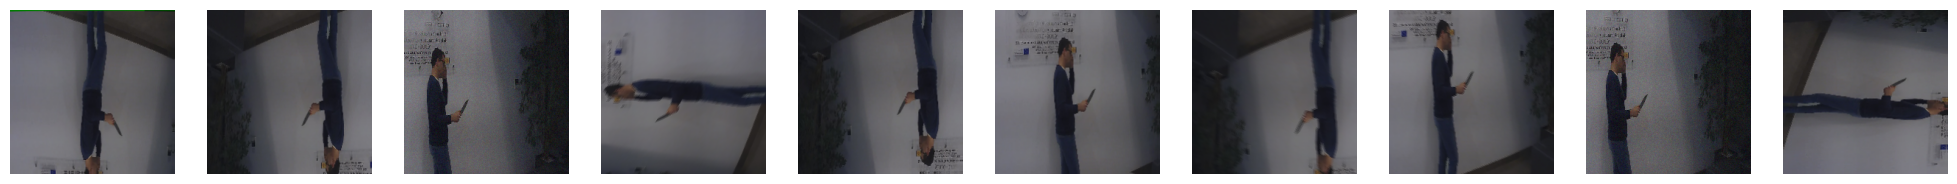

In [26]:
# 확률 기반 Augmentation 조합을 10번 적용한 결과
albumentation_dataset_oneof = AlbumentationsDataset(
    path = '/content/Sohas_weapon-Detection/images',
    transform = albumentations_transform_oneof
)

num_samples = 10
fig, ax = plt.subplots(1, num_samples, figsize=(25, 5))
for i in range(num_samples):
  ax[i].imshow(transforms.ToPILImage()(albumentation_dataset_oneof[0][0]))
  ax[i].axis('off')

In [28]:
### 바운딩 박스 Augmentation
# dataset 크래스 정의
class BboxAugmentationDataset(Dataset):
  # dataset 초기화
  def __init__(self, path, transform = None):
    self.path = path
    self.imgs = list(sorted(os.listdir(self.path)))
    self.transform = transform

  # dataset 크기 계산
  def __len__(self):
    return len(self.imgs)

  # dataset 불러오기(이미지 + 메타 데이터)
  def __getitem__(self, idx):
    file_image = self.imgs[idx]
    file_label = self.imgs[idx][:-3] + 'xml'
    img_path = os.path.join(self.path, file_image)

    if 'test' in self.path:
      label_path = os.path.join('/content/Sohas_weapon-Detection/anntations_test/xmls', file_label)
    else:
      label_path = os.path.join('/content/Sohas_weapon-Detection/annotations/xmls', file_label)

      image = cv2.imread(img_path)
      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

      target = generate_target(label_path)

    # 메타데이터도 transform적
    if self.transform:
      transformed = self.transform(image = image, bboxes = target['boxes'], labels = target['labels'])
      image = transformed['image']
      target = {'boxes':transformed['bboxes'], 'labels':transformed['labels']}

    return image, target

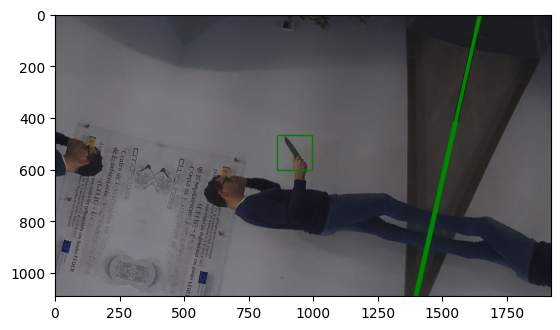

In [30]:
### albumentations.Compose를 이용해 이미지를 변환
# 좌우 반전, -90~90도 회전을 확률 기반으로 시행(바운딩 박스도 함께 처리)
bbox_transform = albumentations.Compose(
    [albumentations.HorizontalFlip(p=1),
     albumentations.Rotate(p=1),
     albumentations.pytorch.transforms.ToTensorV2()],
    bbox_params=albumentations.BboxParams(format='pascal_voc', label_fields=['labels']),
)

# 결과물 확인
bbox_transform_dataset = BboxAugmentationDataset(
    path = '/content/Sohas_weapon-Detection/images',
    transform = bbox_transform
)

img, annot = bbox_transform_dataset[0]
plot_image_from_output(img, annot)

In [35]:
### 데이터 분리
# 전체 데이터의 개수 확인
print(len(os.listdir('/content/Sohas_weapon-Detection/annotations/xmls')))
print(len(os.listdir('/content/Sohas_weapon-Detection/images')))

1000
1000


In [38]:
# test 데이터를 담을 폴더 생성
!mkdir Sohas_weapon-Detection/test_images
!mkdir Sohas_weapon-Detection/test_annotations

In [45]:
# 전체 데이터를 8:2로 학습 데이터, 시험 데이터로 분리
import random

random.seed(1234)
idx = random.sample(range(1000), 200)
print(len(idx))
print(idx[:10])

200
[585, 33, 439, 494, 591, 15, 211, 473, 832, 503]


In [46]:
# 분리한 데이터를 시험 데이터 폴더로 옮기는 과정
import numpy as np
import shutil

for img in np.array(sorted(os.listdir('/content/Sohas_weapon-Detection/images')))[idx]:
  shutil.move('/content/Sohas_weapon-Detection/images/'+img, '/content/Sohas_weapon-Detection/test_images/' + img)

for annot in np.array(sorted(os.listdir('/content/Sohas_weapon-Detection/annotations/xmls')))[idx]:
  shutil.move('/content/Sohas_weapon-Detection/annotations/xlms/'+annot, '/content/Sohas_weapon-Detection/test_annotations/' + annot)

IndexError: ignored

In [50]:
# 학습용 데이터와 시험용 데이터 분리 확
print(len(os.listdir('/content/Sohas_weapon-Detection/annotations/xlms')))
print(len(os.listdir('/content/Sohas_weapon-Detection/images')))
print(len(os.listdir('/content/Sohas_weapon-Detection/test_annotations')))
print(len(os.listdir('/content/Sohas_weapon-Detection/test_images')))

FileNotFoundError: ignored

In [ ]:
# 각 클래스 별로 몇 개의 객체가 데이터셋 내부에 존재하는지 확인
from tqdm import tqdm
import pandas as pd
from collections import Counter

# 데이터셋에 있는 모든 바운딩 박스의 메타 데이터를 total_labels에 저장후 메타 데이터별 개수 반환
def get_num_objects_for_each_class(dataset):

    total_labels = []

    for img, annot in tqdm(dataset, position = 0, leave = True):
        total_labels += [int(i) for i in annot['labels']]

    return Counter(total_labels)


train_data =  BboxAugmentationDataset(
    path = '/content/Sohas_weapon-Detection/images/'
)

test_data =  BboxAugmentationDataset(
    path = '/content/Sohas_weapon-Detection/test_images/'
)

train_objects = get_num_objects_for_each_class(train_data)
test_objects = get_num_objects_for_each_class(test_data)

print('\n train 데이터에 있는 객체', train_objects)
print('\n test 데이터에 있는 객체', test_objects)